In [1]:
#Bank Scoring project

#This project is made as a part of Data Science course, ML blok, Supervised Learning section.

#The goal of this project is to build a ML model that predict the default Risk of the bank's customers 
#and to obtain a satisfied value of a test metric

#As a model type I chose gradient boosting model Catboost

#Test metric for evaluation will be ROC AUC score 

#Objective is to reach <0.77 ROC AUC threshold

In [2]:
#Working directory
%cd C:/Users/Public/Portfolio/3 Default Risk

C:\Users\Public\Portfolio\3 Default Risk


In [3]:
#Installing libraries
import os
import time
from typing import Optional

import numpy as np
import pandas as pd
import catboost as cb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [4]:
#Reading the data

In [5]:
def get_input(data_path: str) -> pd.DataFrame:
    """
    Reading data and returning information about the dataset

    Parameters
    ----------
    data_path: str
        File name

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Number of columns and rows in pandas.DataFrame

    """
    base_path = "./data/"
    data = pd.read_csv(f"{base_path}/{data_path}")
    data.columns = [col.lower() for col in data.columns]
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

In [6]:
train = get_input("train.csv")
train.head(2)

train.csv: shape = 215257 rows, 122 cols


,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,342217,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,2.0
1,183133,0,Cash loans,F,N,Y,0,112500.0,656811.0,30564.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [63]:
test = get_input("test.csv")
test.head(2)

test.csv: shape = 92254 rows, 121 cols


,sk_id_curr,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,174545,Cash loans,F,N,Y,0,135000.0,654498.0,31617.0,585000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,209898,Cash loans,M,Y,Y,0,135000.0,234576.0,25393.5,202500.0,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0


In [8]:
applications = get_input("previous_application.csv")
applications.head(2)

previous_application.csv: shape = 1670214 rows, 37 cols


,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,...,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0


In [9]:
payments = get_input("installments_payments.csv")
payments.head(2)

installments_payments.csv: shape = 13605401 rows, 8 cols


,sk_id_prev,sk_id_curr,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525


In [10]:
bureau = get_input("bureau.csv")
bureau.head(2)

bureau.csv: shape = 1716428 rows, 17 cols


,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN


In [11]:
credit_card_balance = get_input("credit_card_balance.csv")
credit_card_balance.head(2)

credit_card_balance.csv: shape = 3840312 rows, 23 cols


,sk_id_prev,sk_id_curr,months_balance,amt_balance,amt_credit_limit_actual,amt_drawings_atm_current,amt_drawings_current,amt_drawings_other_current,amt_drawings_pos_current,amt_inst_min_regularity,...,amt_recivable,amt_total_receivable,cnt_drawings_atm_current,cnt_drawings_current,cnt_drawings_other_current,cnt_drawings_pos_current,cnt_instalment_mature_cum,name_contract_status,sk_dpd,sk_dpd_def
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0


In [12]:
balance = get_input("POS_CASH_balance.csv")
balance.head(2)

POS_CASH_balance.csv: shape = 10001358 rows, 8 cols


,sk_id_prev,sk_id_curr,months_balance,cnt_instalment,cnt_instalment_future,name_contract_status,sk_dpd,sk_dpd_def
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0


In [13]:
#Visualisation of the categorical variables

In [13]:
def plot_categorical(data, col, size=[8 ,4], xlabel_angle=0, title=''):
    """
    Visualization of the categorical features

    """
    plotdata = data[col].value_counts()
    plt.figure(figsize = size)
    sns.barplot(x = plotdata.index, y=plotdata.values, palette="viridis")
    plt.title(title)
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)

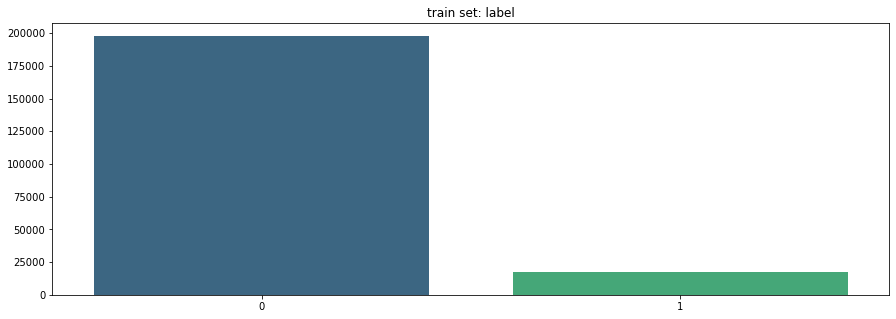

In [12]:
plot_categorical(
    data=train, col='target', size=[15, 5], xlabel_angle=0, title='train set: label')

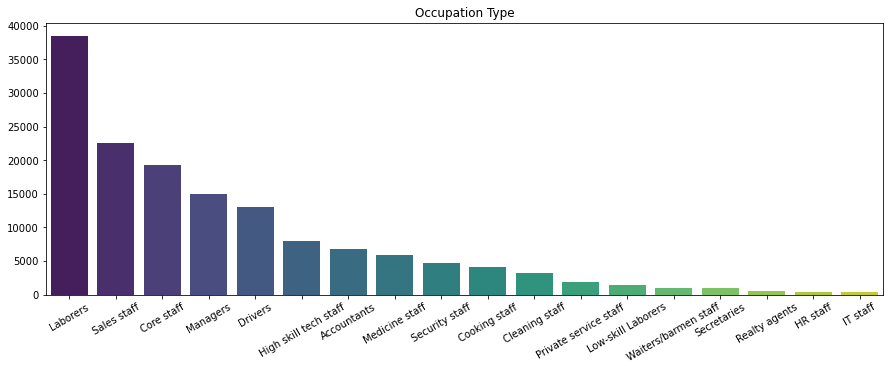

In [14]:
plot_categorical(
    data=train, col='occupation_type', size=[15, 5], xlabel_angle=30, title='Occupation Type')

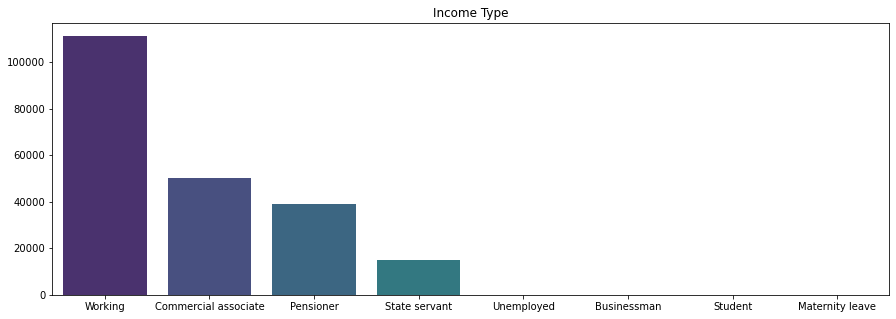

In [15]:
plot_categorical(
    data=train, col='name_income_type', size=[15, 5], xlabel_angle=0, title='Income Type')

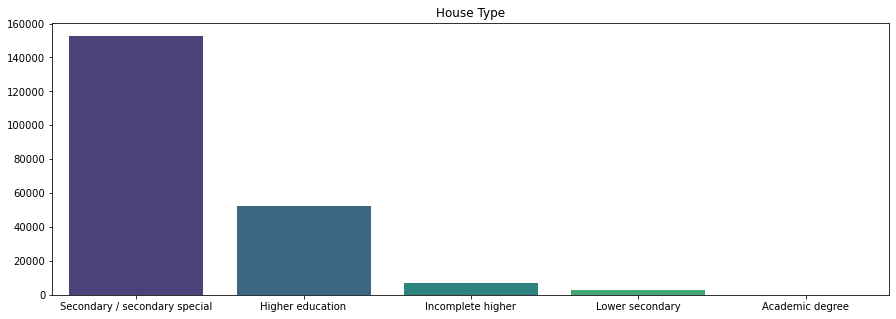

In [16]:
plot_categorical(
    data=train, col='name_education_type', size=[15, 5], xlabel_angle=0, title='House Type')

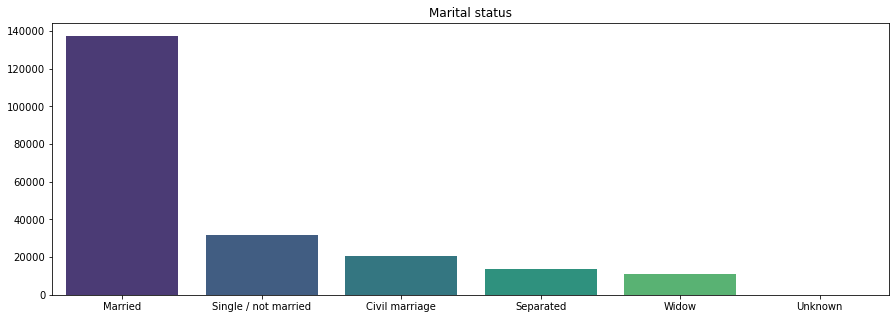

In [17]:
plot_categorical(
    data=train, col='name_family_status', size=[15, 5], xlabel_angle=0, title='Marital status')

In [ ]:
#Handling missing values

In [14]:
def check_missings(X: pd.DataFrame):
    """
    Calculation the number of missing values in the dataset;

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Data for evaluation

    Returns
    -------
    na_stats: pandas.core.frame.DataFrame
        Stats of missing values
    
    """
    total = X.isnull().sum().sort_values(ascending = False)
    percent = round((X.isnull().sum()/X.isnull().count()*100),2).sort_values(ascending = False)
    na_stats = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return na_stats.T


In [15]:
def columns_to_drop(X: pd.DataFrame, t: int):
    """
    Returning of columns with certain proportion of missing values

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Data for evaluation
    t: int
        threshold for missing values

    Returns
    -------
    ds.columns: list
        Names of the columns with missing values above threshold
    
    """
    above_threshold = X.iloc[1:,] > t
    ds = above_threshold.loc[:,~(above_threshold==False).any()]
    return list(ds.columns)


In [16]:
#Train
check_missings(train)

,commonarea_medi,commonarea_avg,commonarea_mode,nonlivingapartments_mode,nonlivingapartments_avg,nonlivingapartments_medi,fondkapremont_mode,livingapartments_mode,livingapartments_avg,livingapartments_medi,...,days_id_publish,days_registration,days_employed,days_birth,region_population_relative,name_housing_type,name_family_status,name_education_type,name_income_type,sk_id_curr
Total,150190.00,150190.00,150190.00,149242.00,149242.00,149242.00,147039.00,146907.00,146907.00,146907.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,69.77,69.77,69.77,69.33,69.33,69.33,68.31,68.25,68.25,68.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#Convert missing values to zeros
train = train.fillna(0)

In [18]:
#Applications
check_missings(applications)

,rate_interest_privileged,rate_interest_primary,amt_down_payment,rate_down_payment,name_type_suite,nflag_insured_on_approval,days_termination,days_last_due,days_last_due_1st_version,days_first_due,...,days_decision,name_contract_status,name_cash_loan_purpose,nflag_last_appl_in_day,flag_last_appl_per_contract,hour_appr_process_start,weekday_appr_process_start,amt_application,name_contract_type,name_payment_type
Total,1664263.00,1664263.00,895844.00,895844.00,820405.00,673065.0,673065.0,673065.0,673065.0,673065.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,99.64,99.64,53.64,53.64,49.12,40.3,40.3,40.3,40.3,40.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#Dropping the columns with over 60% of missing values and convert missing values to zeros
applications = applications.drop(columns_to_drop(check_missings(applications),60), axis=1)
applications = applications.fillna(0)

In [20]:
#Payments
check_missings(payments)

,days_entry_payment,amt_payment,sk_id_prev,sk_id_curr,num_instalment_version,num_instalment_number,days_instalment,amt_instalment
Total,2905.00,2905.00,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.02,0.02,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
payments = payments.fillna(0)

In [22]:
#Bureau
check_missings(bureau)

,amt_annuity,amt_credit_max_overdue,days_enddate_fact,amt_credit_sum_limit,amt_credit_sum_debt,days_credit_enddate,amt_credit_sum,credit_active,credit_currency,days_credit,credit_day_overdue,sk_id_bureau,cnt_credit_prolong,amt_credit_sum_overdue,credit_type,days_credit_update,sk_id_curr
Total,1226791.00,1124488.00,633653.00,591780.00,257669.00,105553.00,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,71.47,65.51,36.92,34.48,15.01,6.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
bureau = bureau.drop(columns_to_drop(check_missings(bureau),60), axis=1)
bureau  = bureau.fillna(0)

In [24]:
#Credit_card_balance
check_missings(credit_card_balance)

,amt_payment_current,amt_drawings_atm_current,cnt_drawings_pos_current,amt_drawings_other_current,amt_drawings_pos_current,cnt_drawings_other_current,cnt_drawings_atm_current,cnt_instalment_mature_cum,amt_inst_min_regularity,sk_id_prev,...,cnt_drawings_current,amt_payment_total_current,amt_recivable,amt_receivable_principal,sk_id_curr,amt_drawings_current,amt_credit_limit_actual,amt_balance,months_balance,sk_dpd_def
Total,767988.0,749816.00,749816.00,749816.00,749816.00,749816.00,749816.00,305236.00,305236.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,20.0,19.52,19.52,19.52,19.52,19.52,19.52,7.95,7.95,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
credit_card_balance  = credit_card_balance.fillna(0)

In [26]:
#Balance
check_missings(balance)

,cnt_instalment_future,cnt_instalment,sk_id_prev,sk_id_curr,months_balance,name_contract_status,sk_dpd,sk_dpd_def
Total,26087.00,26071.00,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.26,0.26,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
balance = balance.fillna(0)

In [28]:
#Data source analysis

In [29]:
n_clients = train["sk_id_curr"].nunique()

print(f"Applications: {train.shape[0]} rows")
print(f"Unique clients: {n_clients} vs {train.shape[0]} rows")

Applications: 215257 rows
Unique clients: 215257 vs 215257 rows


In [38]:
n_clients = applications["sk_id_curr"].nunique()

print(f"Applications: {applications.shape[0]} rows")
print(f"Unique clients: {n_clients}")


Applications: 1670214 rows
Unique clients: 338857


In [39]:
n_clients = payments["sk_id_curr"].nunique()

print(f"payments: {payments.shape[0]} rows")
print(f"Unique clients: {n_clients}")

payments: 13605401 rows
Unique clients: 339587


In [40]:
n_clients = bureau["sk_id_curr"].nunique()

print(f"credit history bureau: {bureau.shape[0]} rows")
print(f"Unique clients: {n_clients}")

credit history bureau: 1716428 rows
Unique clients: 305811


In [41]:
n_clients = credit_card_balance["sk_id_curr"].nunique()

print(f"credit_card_balance: {credit_card_balance.shape[0]} rows")
print(f"Unique clients: {n_clients}")

credit_card_balance: 3840312 rows
Unique clients: 103558


In [42]:
n_clients = balance["sk_id_curr"].nunique()

print(f"balance: {balance.shape[0]} rows")
print(f"Unique clients: {n_clients}")

balance: 10001358 rows
Unique clients: 337252


In [30]:
#Handling categorical values (One-Hot Encoding)

In [31]:
#Applications
applications_cat = list(applications.select_dtypes(include='object').columns)
applications = pd.get_dummies(applications, columns =  applications_cat, drop_first = False)
applications

,sk_id_prev,sk_id_curr,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,hour_appr_process_start,nflag_last_appl_in_day,rate_down_payment,...,product_combination_Cash X-Sell: low,product_combination_Cash X-Sell: middle,product_combination_POS household with interest,product_combination_POS household without interest,product_combination_POS industry with interest,product_combination_POS industry without interest,product_combination_POS mobile with interest,product_combination_POS mobile without interest,product_combination_POS other with interest,product_combination_POS others without interest
0,2030495,271877,1730.430,17145.0,17145.0,0.0,17145.0,15,1,0.000000,...,0,0,0,0,0,0,1,0,0,0
1,2802425,108129,25188.615,607500.0,679671.0,0.0,607500.0,11,1,0.000000,...,1,0,0,0,0,0,0,0,0,0
2,2523466,122040,15060.735,112500.0,136444.5,0.0,112500.0,11,1,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,2819243,176158,47041.335,450000.0,470790.0,0.0,450000.0,7,1,0.000000,...,0,1,0,0,0,0,0,0,0,0
4,1784265,202054,31924.395,337500.0,404055.0,0.0,337500.0,9,1,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,14704.290,267295.5,311400.0,0.0,267295.5,12,1,0.000000,...,0,0,0,0,1,0,0,0,0,0
1670210,2357031,334635,6622.020,87750.0,64291.5,29250.0,87750.0,15,1,0.340554,...,0,0,0,0,1,0,0,0,0,0
1670211,2659632,249544,11520.855,105237.0,102523.5,10525.5,105237.0,12,1,0.101401,...,0,0,1,0,0,0,0,0,0,0
1670212,2785582,400317,18821.520,180000.0,191880.0,0.0,180000.0,9,1,0.000000,...,1,0,0,0,0,0,0,0,0,0


In [32]:
#Payments dataset has no categorical columns

In [33]:
#Bureau
bureau_cat = list(bureau.select_dtypes(include='object').columns)
bureau = pd.get_dummies(bureau, columns =  bureau_cat, drop_first = False)
bureau

,sk_id_curr,sk_id_bureau,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,...,credit_type_Interbank credit,credit_type_Loan for business development,credit_type_Loan for purchase of shares (margin lending),credit_type_Loan for the purchase of equipment,credit_type_Loan for working capital replenishment,credit_type_Microloan,credit_type_Mobile operator loan,credit_type_Mortgage,credit_type_Real estate loan,credit_type_Unknown type of loan
0,215354,5714462,-497,0,-153.0,-153.0,0,91323.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,215354,5714463,-208,0,1075.0,0.0,0,225000.00,171342.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,215354,5714464,-203,0,528.0,0.0,0,464323.50,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,215354,5714465,-203,0,0.0,0.0,0,90000.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,215354,5714466,-629,0,1197.0,0.0,0,2700000.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,-44,0,-30.0,0.0,0,11250.00,11250.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1716424,100044,5057754,-2648,0,-2433.0,-2493.0,0,38130.84,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1716425,100044,5057762,-1809,0,-1628.0,-970.0,0,15570.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1716426,246829,5057770,-1878,0,-1513.0,-1513.0,0,36000.00,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#Credit_card_balance
credit_card_balance_cat = list(credit_card_balance.select_dtypes(include='object').columns)
credit_card_balance = pd.get_dummies(credit_card_balance, columns =  credit_card_balance_cat, drop_first = False)
credit_card_balance

,sk_id_prev,sk_id_curr,months_balance,amt_balance,amt_credit_limit_actual,amt_drawings_atm_current,amt_drawings_current,amt_drawings_other_current,amt_drawings_pos_current,amt_inst_min_regularity,...,cnt_instalment_mature_cum,sk_dpd,sk_dpd_def,name_contract_status_Active,name_contract_status_Approved,name_contract_status_Completed,name_contract_status_Demand,name_contract_status_Refused,name_contract_status_Sent proposal,name_contract_status_Signed
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,35.0,0,0,1,0,0,0,0,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,69.0,0,0,1,0,0,0,0,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,30.0,0,0,1,0,0,0,0,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,10.0,0,0,1,0,0,0,0,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,101.0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.0,0,0,1,0,0,0,0,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,23.0,0,0,1,0,0,0,0,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,18.0,0,0,1,0,0,0,0,0,0
3840310,1624872,430337,-10,0.000,450000,0.0,0.0,0.0,0.0,0.000,...,0.0,0,0,1,0,0,0,0,0,0


In [35]:
#Balance
balance_cat = list(balance.select_dtypes(include='object').columns)
balance = pd.get_dummies(balance, columns =  balance_cat, drop_first = False)
balance

,sk_id_prev,sk_id_curr,months_balance,cnt_instalment,cnt_instalment_future,sk_dpd,sk_dpd_def,name_contract_status_Active,name_contract_status_Amortized debt,name_contract_status_Approved,name_contract_status_Canceled,name_contract_status_Completed,name_contract_status_Demand,name_contract_status_Returned to the store,name_contract_status_Signed,name_contract_status_XNA
0,1803195,182943,-31,48.0,45.0,0,0,1,0,0,0,0,0,0,0,0
1,1715348,367990,-33,36.0,35.0,0,0,1,0,0,0,0,0,0,0,0
2,1784872,397406,-32,12.0,9.0,0,0,1,0,0,0,0,0,0,0,0
3,1903291,269225,-35,48.0,42.0,0,0,1,0,0,0,0,0,0,0,0
4,2341044,334279,-35,36.0,35.0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,843,0,1,0,0,0,0,0,0,0,0
10001354,1717234,141565,-19,12.0,0.0,602,0,1,0,0,0,0,0,0,0,0
10001355,1283126,315695,-21,10.0,0.0,609,0,1,0,0,0,0,0,0,0,0
10001356,1082516,450255,-22,12.0,0.0,614,0,1,0,0,0,0,0,0,0,0


In [36]:
#Aggreration

In [37]:
def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: Optional[str] = None,
                          suffix: Optional[str] = None,
                          ) -> pd.DataFrame:
    """
    Aggregation for numerical features

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Dataset for aggregation

    groupby_id: str
        Name of the column to group by

    aggs: dict
        Dictionary with function and list of features
        
    prefix: str, optional, default = None
        Prefix for feature names
        The optional parameter is not used by default

    suffix: str, optional, default = None
        Suffix for feature names.
         The optional parameter is not used by default

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Aggregated dataset

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

In [38]:
#Applications
applications_num_col = list(applications.select_dtypes(['float64', 'int64','uint8']).columns)


aggs_appl = list(applications[applications_num_col])
appl_aggs = { i : [np.sum] for i in aggs_appl}

applications_num = create_numerical_aggs(applications[applications_num_col],
                          'sk_id_curr',
                          appl_aggs).drop(['SK_ID_PREV_SUM','SK_ID_CURR_SUM'], axis=1)
applications_num


,sk_id_curr,AMT_ANNUITY_SUM,AMT_APPLICATION_SUM,AMT_CREDIT_SUM,AMT_DOWN_PAYMENT_SUM,AMT_GOODS_PRICE_SUM,HOUR_APPR_PROCESS_START_SUM,NFLAG_LAST_APPL_IN_DAY_SUM,RATE_DOWN_PAYMENT_SUM,DAYS_DECISION_SUM,...,PRODUCT_COMBINATION_CASH X-SELL: LOW_SUM,PRODUCT_COMBINATION_CASH X-SELL: MIDDLE_SUM,PRODUCT_COMBINATION_POS HOUSEHOLD WITH INTEREST_SUM,PRODUCT_COMBINATION_POS HOUSEHOLD WITHOUT INTEREST_SUM,PRODUCT_COMBINATION_POS INDUSTRY WITH INTEREST_SUM,PRODUCT_COMBINATION_POS INDUSTRY WITHOUT INTEREST_SUM,PRODUCT_COMBINATION_POS MOBILE WITH INTEREST_SUM,PRODUCT_COMBINATION_POS MOBILE WITHOUT INTEREST_SUM,PRODUCT_COMBINATION_POS OTHER WITH INTEREST_SUM,PRODUCT_COMBINATION_POS OTHERS WITHOUT INTEREST_SUM
0,100001,3951.000,24835.5,23787.0,2520.0,24835.5,13,1,0.104326,-1740,...,0,0,0,0,0,0,1,0,0,0
1,100002,9251.775,179055.0,179055.0,0.0,179055.0,9,1,0.000000,-606,...,0,0,0,0,0,0,0,0,1,0
2,100003,169661.970,1306309.5,1452573.0,6885.0,1306309.5,44,3,0.100061,-3915,...,1,0,1,0,1,0,0,0,0,0
3,100004,5357.250,24282.0,20106.0,4860.0,24282.0,5,1,0.212008,-815,...,0,0,0,0,0,0,0,1,0,0
4,100005,4813.200,44617.5,40153.5,4464.0,44617.5,21,2,0.108964,-1072,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,6605.910,40455.0,40455.0,0.0,40455.0,17,1,0.000000,-273,...,0,0,0,0,0,0,1,0,0,0
338853,456252,10074.465,57595.5,56821.5,3456.0,57595.5,10,1,0.062443,-2497,...,0,0,0,1,0,0,0,0,0,0
338854,456253,9540.810,48325.5,41251.5,8806.5,48325.5,23,2,0.428633,-4760,...,0,0,0,0,0,0,2,0,0,0
338855,456254,21362.265,242635.5,268879.5,0.0,242635.5,30,2,0.000000,-599,...,0,0,1,0,0,0,1,0,0,0


In [39]:
#Payments
payments_num_col = list(payments.select_dtypes(['float64', 'int64']).columns)


aggs_payments = list(payments[payments_num_col])
payments_aggs = { i : [np.sum] for i in aggs_payments}

payments_num = create_numerical_aggs(payments[payments_num_col],
                          'sk_id_curr',
                          payments_aggs).drop(['SK_ID_PREV_SUM','SK_ID_CURR_SUM'], axis=1)
payments_num

,sk_id_curr,NUM_INSTALMENT_VERSION_SUM,NUM_INSTALMENT_NUMBER_SUM,DAYS_INSTALMENT_SUM,DAYS_ENTRY_PAYMENT_SUM,AMT_INSTALMENT_SUM,AMT_PAYMENT_SUM
0,100001,8.0,19,-15314.0,-15365.0,41195.925,41195.925
1,100002,20.0,190,-5605.0,-5993.0,219625.695,219625.695
2,100003,26.0,127,-34454.0,-34633.0,1618864.650,1618864.650
3,100004,4.0,6,-2262.0,-2285.0,21288.465,21288.465
4,100005,10.0,45,-5274.0,-5486.0,56161.845,56161.845
...,...,...,...,...,...,...,...
339582,456251,8.0,28,-840.0,-1094.0,52450.470,52450.470
339583,456252,6.0,21,-14346.0,-14363.0,60419.205,60419.205
339584,456253,14.0,67,-33221.0,-33424.0,61595.910,57622.815
339585,456254,19.0,100,-2703.0,-3064.0,194556.825,194556.825


In [40]:
#Bureau
bureau_num_col = list(bureau.select_dtypes(['float64', 'int64','uint8']).columns)

aggs_bureau = list(bureau[bureau_num_col])
bureau_aggs = { i : [np.sum] for i in aggs_bureau}

bureau_num = create_numerical_aggs(bureau[bureau_num_col],
                          'sk_id_curr',
                          bureau_aggs).drop(['SK_ID_BUREAU_SUM','SK_ID_CURR_SUM'], axis=1)
bureau_num

,sk_id_curr,DAYS_CREDIT_SUM,CREDIT_DAY_OVERDUE_SUM,DAYS_CREDIT_ENDDATE_SUM,DAYS_ENDDATE_FACT_SUM,CNT_CREDIT_PROLONG_SUM,AMT_CREDIT_SUM_SUM,AMT_CREDIT_SUM_DEBT_SUM,AMT_CREDIT_SUM_LIMIT_SUM,AMT_CREDIT_SUM_OVERDUE_SUM,...,CREDIT_TYPE_INTERBANK CREDIT_SUM,CREDIT_TYPE_LOAN FOR BUSINESS DEVELOPMENT_SUM,CREDIT_TYPE_LOAN FOR PURCHASE OF SHARES (MARGIN LENDING)_SUM,CREDIT_TYPE_LOAN FOR THE PURCHASE OF EQUIPMENT_SUM,CREDIT_TYPE_LOAN FOR WORKING CAPITAL REPLENISHMENT_SUM,CREDIT_TYPE_MICROLOAN_SUM,CREDIT_TYPE_MOBILE OPERATOR LOAN_SUM,CREDIT_TYPE_MORTGAGE_SUM,CREDIT_TYPE_REAL ESTATE LOAN_SUM,CREDIT_TYPE_UNKNOWN TYPE OF LOAN_SUM
0,100001,-5145,0,577.0,-3302.0,0,1453365.000,596686.500,0.000,0.0,...,0,0,0,0,0,0,0,0,0,0
1,100002,-6992,0,-2094.0,-4185.0,0,865055.565,245781.000,31988.565,0.0,...,0,0,0,0,0,0,0,0,0,0
2,100003,-5603,0,-2178.0,-3292.0,0,1017400.500,0.000,810000.000,0.0,...,0,0,0,0,0,0,0,0,0,0
3,100004,-1734,0,-977.0,-1065.0,0,189037.800,0.000,0.000,0.0,...,0,0,0,0,0,0,0,0,0,0
4,100005,-572,0,1318.0,-123.0,0,657126.000,568408.500,0.000,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,-21672,0,-14788.0,-16377.0,0,3693858.660,163071.000,0.000,0.0,...,0,0,0,0,0,0,0,0,0,0
305807,456250,-2586,0,3865.0,-760.0,0,3086459.550,2232040.095,58268.385,0.0,...,0,0,0,0,0,0,0,0,0,0
305808,456253,-3470,0,1122.0,-1588.0,0,3960000.000,1795833.000,0.000,0.0,...,0,0,0,0,0,0,0,0,0,0
305809,456254,-1104,0,-859.0,-859.0,0,45000.000,0.000,0.000,0.0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
#Credit_card_balance
credit_card_balance_col = list(credit_card_balance.select_dtypes(['float64', 'int64','uint8']).columns)
credit_card_balance_aggs = list(credit_card_balance[credit_card_balance_col])


credit_card_balance_aggs = { i : [np.sum] for i in credit_card_balance_aggs}

credit_card_balance_num = create_numerical_aggs(credit_card_balance[credit_card_balance_col],
                          'sk_id_curr',
                          credit_card_balance_aggs).drop(['SK_ID_PREV_SUM','SK_ID_CURR_SUM'], axis=1)
credit_card_balance_num

,sk_id_curr,MONTHS_BALANCE_SUM,AMT_BALANCE_SUM,AMT_CREDIT_LIMIT_ACTUAL_SUM,AMT_DRAWINGS_ATM_CURRENT_SUM,AMT_DRAWINGS_CURRENT_SUM,AMT_DRAWINGS_OTHER_CURRENT_SUM,AMT_DRAWINGS_POS_CURRENT_SUM,AMT_INST_MIN_REGULARITY_SUM,AMT_PAYMENT_CURRENT_SUM,...,CNT_INSTALMENT_MATURE_CUM_SUM,SK_DPD_SUM,SK_DPD_DEF_SUM,NAME_CONTRACT_STATUS_ACTIVE_SUM,NAME_CONTRACT_STATUS_APPROVED_SUM,NAME_CONTRACT_STATUS_COMPLETED_SUM,NAME_CONTRACT_STATUS_DEMAND_SUM,NAME_CONTRACT_STATUS_REFUSED_SUM,NAME_CONTRACT_STATUS_SENT PROPOSAL_SUM,NAME_CONTRACT_STATUS_SIGNED_SUM
0,100006,-21,0.000,1620000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0,0,6,0,0,0,0,0,0
1,100011,-2849,4031676.225,12150000,180000.0,180000.000,0.0,0.000,288804.195,358386.750,...,1881.0,0,0,74,0,0,0,0,0,0
2,100013,-4656,1743352.245,12645000,571500.0,571500.000,0.0,0.000,129454.020,688161.240,...,1666.0,1,1,96,0,0,0,0,0,0
3,100021,-170,0.000,11475000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0,0,7,0,10,0,0,0,0
4,100023,-60,0.000,1080000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0,0,8,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103553,456244,-861,5405223.960,12150000,1003500.0,1100537.910,0.0,96883.650,260568.000,1341542.340,...,544.0,0,0,36,0,5,0,0,0,0
103554,456246,-44,105093.855,1080000,0.0,121594.050,0.0,121594.050,11513.205,131447.925,...,28.0,0,0,8,0,0,0,0,0,0
103555,456247,-4655,2205557.640,13680000,202950.0,204203.115,0.0,1253.115,134396.955,463956.750,...,2517.0,3,2,95,0,0,0,0,0,0
103556,456248,-299,0.000,20700000,0.0,0.000,0.0,0.000,0.000,0.000,...,0.0,0,0,23,0,0,0,0,0,0


In [42]:
#Balance
balance_col = list(balance.select_dtypes(['float64', 'int64','uint8']).columns)
balance_aggs = list(balance[balance_col])

balance_aggs = { i : [np.sum] for i in balance_aggs}

balance_num = create_numerical_aggs(balance[balance_col],
                          'sk_id_curr',
                          balance_aggs).drop(['SK_ID_PREV_SUM','SK_ID_CURR_SUM'], axis=1)
balance_num

,sk_id_curr,MONTHS_BALANCE_SUM,CNT_INSTALMENT_SUM,CNT_INSTALMENT_FUTURE_SUM,SK_DPD_SUM,SK_DPD_DEF_SUM,NAME_CONTRACT_STATUS_ACTIVE_SUM,NAME_CONTRACT_STATUS_AMORTIZED DEBT_SUM,NAME_CONTRACT_STATUS_APPROVED_SUM,NAME_CONTRACT_STATUS_CANCELED_SUM,NAME_CONTRACT_STATUS_COMPLETED_SUM,NAME_CONTRACT_STATUS_DEMAND_SUM,NAME_CONTRACT_STATUS_RETURNED TO THE STORE_SUM,NAME_CONTRACT_STATUS_SIGNED_SUM,NAME_CONTRACT_STATUS_XNA_SUM
0,100001,-653,36.0,13.0,7,7,7.0,0,0,0,2,0,0,0,0
1,100002,-190,456.0,285.0,0,0,19.0,0,0,0,0,0,0,0,0
2,100003,-1226,283.0,162.0,0,0,26.0,0,0,0,2,0,0,0,0
3,100004,-102,15.0,9.0,0,0,3.0,0,0,0,1,0,0,0,0
4,100005,-220,117.0,72.0,0,0,9.0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337247,456251,-45,63.0,35.0,0,0,7.0,0,0,0,1,0,0,1,0
337248,456252,-553,42.0,21.0,0,0,6.0,0,0,0,1,0,0,0,0
337249,456253,-1347,114.0,34.0,5,5,15.0,0,0,0,2,0,0,0,0
337250,456254,-111,298.0,207.0,0,0,20.0,0,0,0,0,0,0,0,0


In [43]:
#Merging the datasets

In [44]:
#Applictions + Payments
total = applications_num.merge(payments_num, how="left", on=["sk_id_curr"],suffixes=('', '_y'))
total.drop(total.filter(regex='_y$').columns, axis=1, inplace=True)
total

,sk_id_curr,AMT_ANNUITY_SUM,AMT_APPLICATION_SUM,AMT_CREDIT_SUM,AMT_DOWN_PAYMENT_SUM,AMT_GOODS_PRICE_SUM,HOUR_APPR_PROCESS_START_SUM,NFLAG_LAST_APPL_IN_DAY_SUM,RATE_DOWN_PAYMENT_SUM,DAYS_DECISION_SUM,...,PRODUCT_COMBINATION_POS MOBILE WITH INTEREST_SUM,PRODUCT_COMBINATION_POS MOBILE WITHOUT INTEREST_SUM,PRODUCT_COMBINATION_POS OTHER WITH INTEREST_SUM,PRODUCT_COMBINATION_POS OTHERS WITHOUT INTEREST_SUM,NUM_INSTALMENT_VERSION_SUM,NUM_INSTALMENT_NUMBER_SUM,DAYS_INSTALMENT_SUM,DAYS_ENTRY_PAYMENT_SUM,AMT_INSTALMENT_SUM,AMT_PAYMENT_SUM
0,100001,3951.000,24835.5,23787.0,2520.0,24835.5,13,1,0.104326,-1740,...,1,0,0,0,8.0,19.0,-15314.0,-15365.0,41195.925,41195.925
1,100002,9251.775,179055.0,179055.0,0.0,179055.0,9,1,0.000000,-606,...,0,0,1,0,20.0,190.0,-5605.0,-5993.0,219625.695,219625.695
2,100003,169661.970,1306309.5,1452573.0,6885.0,1306309.5,44,3,0.100061,-3915,...,0,0,0,0,26.0,127.0,-34454.0,-34633.0,1618864.650,1618864.650
3,100004,5357.250,24282.0,20106.0,4860.0,24282.0,5,1,0.212008,-815,...,0,1,0,0,4.0,6.0,-2262.0,-2285.0,21288.465,21288.465
4,100005,4813.200,44617.5,40153.5,4464.0,44617.5,21,2,0.108964,-1072,...,1,0,0,0,10.0,45.0,-5274.0,-5486.0,56161.845,56161.845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,6605.910,40455.0,40455.0,0.0,40455.0,17,1,0.000000,-273,...,1,0,0,0,8.0,28.0,-840.0,-1094.0,52450.470,52450.470
338853,456252,10074.465,57595.5,56821.5,3456.0,57595.5,10,1,0.062443,-2497,...,0,0,0,0,6.0,21.0,-14346.0,-14363.0,60419.205,60419.205
338854,456253,9540.810,48325.5,41251.5,8806.5,48325.5,23,2,0.428633,-4760,...,2,0,0,0,14.0,67.0,-33221.0,-33424.0,61595.910,57622.815
338855,456254,21362.265,242635.5,268879.5,0.0,242635.5,30,2,0.000000,-599,...,1,0,0,0,19.0,100.0,-2703.0,-3064.0,194556.825,194556.825


In [45]:
#+Bureau
total_bureau_num = total.merge(bureau_num, how="left", on=["sk_id_curr"],suffixes=('', '_y'))
total_bureau_num.drop(total_bureau_num.filter(regex='_y$').columns, axis=1, inplace=True)
total_bureau_num

,sk_id_curr,AMT_ANNUITY_SUM,AMT_APPLICATION_SUM,AMT_CREDIT_SUM,AMT_DOWN_PAYMENT_SUM,AMT_GOODS_PRICE_SUM,HOUR_APPR_PROCESS_START_SUM,NFLAG_LAST_APPL_IN_DAY_SUM,RATE_DOWN_PAYMENT_SUM,DAYS_DECISION_SUM,...,CREDIT_TYPE_INTERBANK CREDIT_SUM,CREDIT_TYPE_LOAN FOR BUSINESS DEVELOPMENT_SUM,CREDIT_TYPE_LOAN FOR PURCHASE OF SHARES (MARGIN LENDING)_SUM,CREDIT_TYPE_LOAN FOR THE PURCHASE OF EQUIPMENT_SUM,CREDIT_TYPE_LOAN FOR WORKING CAPITAL REPLENISHMENT_SUM,CREDIT_TYPE_MICROLOAN_SUM,CREDIT_TYPE_MOBILE OPERATOR LOAN_SUM,CREDIT_TYPE_MORTGAGE_SUM,CREDIT_TYPE_REAL ESTATE LOAN_SUM,CREDIT_TYPE_UNKNOWN TYPE OF LOAN_SUM
0,100001,3951.000,24835.5,23787.0,2520.0,24835.5,13,1,0.104326,-1740,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,9251.775,179055.0,179055.0,0.0,179055.0,9,1,0.000000,-606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,169661.970,1306309.5,1452573.0,6885.0,1306309.5,44,3,0.100061,-3915,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,5357.250,24282.0,20106.0,4860.0,24282.0,5,1,0.212008,-815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100005,4813.200,44617.5,40153.5,4464.0,44617.5,21,2,0.108964,-1072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,6605.910,40455.0,40455.0,0.0,40455.0,17,1,0.000000,-273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338853,456252,10074.465,57595.5,56821.5,3456.0,57595.5,10,1,0.062443,-2497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338854,456253,9540.810,48325.5,41251.5,8806.5,48325.5,23,2,0.428633,-4760,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
338855,456254,21362.265,242635.5,268879.5,0.0,242635.5,30,2,0.000000,-599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
#+Credit_card_balance
total_credit_card_balance = total_bureau_num.merge(credit_card_balance_num, how="left", on=["sk_id_curr"],suffixes=('', '_y'))
total_credit_card_balance.drop(total_credit_card_balance.filter(regex='_y$').columns, axis=1, inplace=True)
total_credit_card_balance

,sk_id_curr,AMT_ANNUITY_SUM,AMT_APPLICATION_SUM,AMT_CREDIT_SUM,AMT_DOWN_PAYMENT_SUM,AMT_GOODS_PRICE_SUM,HOUR_APPR_PROCESS_START_SUM,NFLAG_LAST_APPL_IN_DAY_SUM,RATE_DOWN_PAYMENT_SUM,DAYS_DECISION_SUM,...,CNT_DRAWINGS_OTHER_CURRENT_SUM,CNT_DRAWINGS_POS_CURRENT_SUM,CNT_INSTALMENT_MATURE_CUM_SUM,SK_DPD_SUM,SK_DPD_DEF_SUM,NAME_CONTRACT_STATUS_ACTIVE_SUM,NAME_CONTRACT_STATUS_COMPLETED_SUM,NAME_CONTRACT_STATUS_DEMAND_SUM,NAME_CONTRACT_STATUS_SENT PROPOSAL_SUM,NAME_CONTRACT_STATUS_SIGNED_SUM
0,100001,3951.000,24835.5,23787.0,2520.0,24835.5,13,1,0.104326,-1740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,9251.775,179055.0,179055.0,0.0,179055.0,9,1,0.000000,-606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,169661.970,1306309.5,1452573.0,6885.0,1306309.5,44,3,0.100061,-3915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,5357.250,24282.0,20106.0,4860.0,24282.0,5,1,0.212008,-815,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,4813.200,44617.5,40153.5,4464.0,44617.5,21,2,0.108964,-1072,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,6605.910,40455.0,40455.0,0.0,40455.0,17,1,0.000000,-273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338853,456252,10074.465,57595.5,56821.5,3456.0,57595.5,10,1,0.062443,-2497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338854,456253,9540.810,48325.5,41251.5,8806.5,48325.5,23,2,0.428633,-4760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338855,456254,21362.265,242635.5,268879.5,0.0,242635.5,30,2,0.000000,-599,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
#+Bureau_balance
total_balance_num = total_credit_card_balance.merge(balance_num, how="left", on=["sk_id_curr"])
total_balance_num.drop(total_balance_num.filter(regex='_y$').columns, axis=1, inplace=True)
total_balance_num

,sk_id_curr,AMT_ANNUITY_SUM,AMT_APPLICATION_SUM,AMT_CREDIT_SUM,AMT_DOWN_PAYMENT_SUM,AMT_GOODS_PRICE_SUM,HOUR_APPR_PROCESS_START_SUM,NFLAG_LAST_APPL_IN_DAY_SUM,RATE_DOWN_PAYMENT_SUM,DAYS_DECISION_SUM,...,NAME_CONTRACT_STATUS_ACTIVE_SUM_x,NAME_CONTRACT_STATUS_COMPLETED_SUM_x,NAME_CONTRACT_STATUS_DEMAND_SUM_x,NAME_CONTRACT_STATUS_SENT PROPOSAL_SUM,NAME_CONTRACT_STATUS_SIGNED_SUM_x,CNT_INSTALMENT_SUM,CNT_INSTALMENT_FUTURE_SUM,NAME_CONTRACT_STATUS_AMORTIZED DEBT_SUM,NAME_CONTRACT_STATUS_RETURNED TO THE STORE_SUM,NAME_CONTRACT_STATUS_XNA_SUM
0,100001,3951.000,24835.5,23787.0,2520.0,24835.5,13,1,0.104326,-1740,...,NaN,NaN,NaN,NaN,NaN,36.0,13.0,0.0,0.0,0.0
1,100002,9251.775,179055.0,179055.0,0.0,179055.0,9,1,0.000000,-606,...,NaN,NaN,NaN,NaN,NaN,456.0,285.0,0.0,0.0,0.0
2,100003,169661.970,1306309.5,1452573.0,6885.0,1306309.5,44,3,0.100061,-3915,...,NaN,NaN,NaN,NaN,NaN,283.0,162.0,0.0,0.0,0.0
3,100004,5357.250,24282.0,20106.0,4860.0,24282.0,5,1,0.212008,-815,...,NaN,NaN,NaN,NaN,NaN,15.0,9.0,0.0,0.0,0.0
4,100005,4813.200,44617.5,40153.5,4464.0,44617.5,21,2,0.108964,-1072,...,NaN,NaN,NaN,NaN,NaN,117.0,72.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,6605.910,40455.0,40455.0,0.0,40455.0,17,1,0.000000,-273,...,NaN,NaN,NaN,NaN,NaN,63.0,35.0,0.0,0.0,0.0
338853,456252,10074.465,57595.5,56821.5,3456.0,57595.5,10,1,0.062443,-2497,...,NaN,NaN,NaN,NaN,NaN,42.0,21.0,0.0,0.0,0.0
338854,456253,9540.810,48325.5,41251.5,8806.5,48325.5,23,2,0.428633,-4760,...,NaN,NaN,NaN,NaN,NaN,114.0,34.0,0.0,0.0,0.0
338855,456254,21362.265,242635.5,268879.5,0.0,242635.5,30,2,0.000000,-599,...,NaN,NaN,NaN,NaN,NaN,298.0,207.0,0.0,0.0,0.0


In [48]:
#Total dadaset
total = train.merge(total_balance_num, how="left", on=["sk_id_curr"])
total

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,NAME_CONTRACT_STATUS_ACTIVE_SUM_x,NAME_CONTRACT_STATUS_COMPLETED_SUM_x,NAME_CONTRACT_STATUS_DEMAND_SUM_x,NAME_CONTRACT_STATUS_SENT PROPOSAL_SUM,NAME_CONTRACT_STATUS_SIGNED_SUM_x,CNT_INSTALMENT_SUM,CNT_INSTALMENT_FUTURE_SUM,NAME_CONTRACT_STATUS_AMORTIZED DEBT_SUM,NAME_CONTRACT_STATUS_RETURNED TO THE STORE_SUM,NAME_CONTRACT_STATUS_XNA_SUM
0,342217,0,Revolving loans,F,N,Y,0,202500.0,585000.0,29250.0,...,NaN,NaN,NaN,NaN,NaN,124.0,73.0,0.0,0.0,0.0
1,183133,0,Cash loans,F,N,Y,0,112500.0,656811.0,30564.0,...,96.0,0.0,0.0,0.0,0.0,1973.0,1101.0,0.0,0.0,0.0
2,449106,0,Revolving loans,M,N,Y,0,144000.0,450000.0,22500.0,...,NaN,NaN,NaN,NaN,NaN,951.0,545.0,0.0,0.0,0.0
3,351350,0,Cash loans,F,N,Y,1,450000.0,1483231.5,51687.0,...,NaN,NaN,NaN,NaN,NaN,144.0,78.0,0.0,0.0,0.0
4,226525,0,Cash loans,M,Y,Y,0,202500.0,454500.0,19255.5,...,22.0,0.0,0.0,0.0,1.0,285.0,151.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215252,124980,0,Cash loans,F,N,Y,1,292500.0,2013840.0,53253.0,...,89.0,0.0,0.0,0.0,0.0,102.0,36.0,0.0,0.0,0.0
215253,236346,0,Cash loans,F,N,Y,0,157500.0,599778.0,32665.5,...,35.0,0.0,0.0,0.0,0.0,1336.0,858.0,0.0,0.0,0.0
215254,185050,0,Revolving loans,F,N,Y,2,135000.0,270000.0,13500.0,...,NaN,NaN,NaN,NaN,NaN,122.0,61.0,0.0,0.0,0.0
215255,409734,0,Cash loans,M,N,Y,1,135000.0,781920.0,47835.0,...,11.0,0.0,0.0,0.0,0.0,406.0,278.0,0.0,0.0,0.0


In [51]:
#Building ML model (catboost)

In [49]:
def catboost_hold_out_validation(params, X, y, split_params = [0.7, 0.2, 0.1], categorical = None):
    """
    Hold-Out validation for catbooost

    Parameters
    ----------
    params: dict
        Dictionary of model parameters

    X: pandas.core.frame.DataFrame
        Feature matrix for training the model

    y: pandas.core.frame.Series
        The vector of the target feature for training the model

    split_params: List[float], optional, default = [0.7, 0.2, 0.1]
        Parameters of splitting the sample
        By default [0.7, 0.2, 0.1]
    
    categorical: str, optional, default = None
        List of categorical features

    Returns
    -------
    estimator: catboost.core.CatBoostClassifier
        Trained catboost classifier

    test_prediction: np.array, optional
        The prediction vector for the test dataset

    """
    print(f"Starting at {time.ctime()}")
    numeric = list(set(X.columns) - set(categorical))
    if categorical:
        X[categorical] = X[categorical].astype(str)

    x_train, x_valid = train_test_split(
        X, train_size=split_params[0], random_state=27
    )
    y_train, y_valid = train_test_split(
        y, train_size=split_params[0], random_state=27
    )

    if len(split_params) == 3:
        test_size = int(split_params[2] * X.shape[0])

        x_valid, x_test = train_test_split(
            x_valid, test_size=test_size, random_state=72
        )
        y_valid, y_test = train_test_split(
            y_valid, test_size=test_size, random_state=72
        )

    model = cb.CatBoostClassifier(**params)
    model.fit(
        x_train, y_train, categorical,
        eval_set=[(x_train, y_train), (x_valid, y_valid)]
    )

    print("="*80)
    valid_score = roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])
    print(f"Valid Score = {round(valid_score, 4)}")

    if len(split_params) == 3:

        test_prediction = model.predict_proba(x_test)[:, 1]
        test_score = roc_auc_score(y_test, test_prediction)
        print(f"Test Score = {round(test_score, 4)}")

        return model, test_prediction

    else:
        return model



In [51]:
#Training the model

y_train = total["target"]
X_train = total.drop(["target", "sk_id_curr"], axis=1)
categorical = X_train.dtypes[X_train.dtypes == "object"]
categorical = list(categorical.index)

cb_params = {
    "n_estimators": 1200,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "verbose": 25,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

estimators, prediction = catboost_hold_out_validation(
    params=cb_params, X=X_train, y=y_train, categorical=categorical
)

Starting at Fri Feb 17 15:04:10 2023
0:	test: 0.6183602	test1: 0.6213078	best: 0.6213078 (0)	total: 394ms	remaining: 7m 52s
25:	test: 0.7041111	test1: 0.7088703	best: 0.7088703 (25)	total: 10.1s	remaining: 7m 34s
50:	test: 0.7078588	test1: 0.7117808	best: 0.7128751 (45)	total: 18.8s	remaining: 7m 2s
75:	test: 0.7129416	test1: 0.7161371	best: 0.7163120 (69)	total: 27.8s	remaining: 6m 50s
100:	test: 0.7163255	test1: 0.7193321	best: 0.7195031 (99)	total: 36.9s	remaining: 6m 40s
125:	test: 0.7221210	test1: 0.7251033	best: 0.7251033 (125)	total: 46.2s	remaining: 6m 33s
150:	test: 0.7278064	test1: 0.7302079	best: 0.7302079 (150)	total: 55.5s	remaining: 6m 25s
175:	test: 0.7329407	test1: 0.7348955	best: 0.7348955 (175)	total: 1m 5s	remaining: 6m 18s
200:	test: 0.7369702	test1: 0.7384244	best: 0.7384244 (200)	total: 1m 14s	remaining: 6m 10s
225:	test: 0.7406518	test1: 0.7413146	best: 0.7413146 (225)	total: 1m 23s	remaining: 6m 1s
250:	test: 0.7438367	test1: 0.7439620	best: 0.7439620 (250)	tota

In [64]:
#Testing the model
test

,sk_id_curr,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,174545,Cash loans,F,N,Y,0,135000.0,654498.0,31617.0,585000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,209898,Cash loans,M,Y,Y,0,135000.0,234576.0,25393.5,202500.0,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
2,454938,Cash loans,M,Y,Y,0,112500.0,157914.0,16753.5,139500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,398930,Cash loans,M,Y,N,0,247500.0,1125000.0,36292.5,1125000.0,...,0,0,0,0,0.0,0.0,0.0,9.0,0.0,1.0
4,201672,Cash loans,M,N,Y,0,202500.0,900000.0,35158.5,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92249,214360,Cash loans,M,N,Y,0,81000.0,808650.0,26217.0,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
92250,338256,Cash loans,F,N,Y,1,99000.0,135000.0,10822.5,135000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
92251,247835,Cash loans,F,N,Y,1,157500.0,675000.0,38880.0,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
92252,154418,Cash loans,F,Y,Y,0,112500.0,1006920.0,42790.5,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [65]:
#Filling missing values with zeros
test = test.fillna(0)

In [66]:
#Merging test dataset
total_test = test.merge(total_balance_num, how="left", on=["sk_id_curr"])
total_test

,sk_id_curr,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,...,NAME_CONTRACT_STATUS_ACTIVE_SUM_x,NAME_CONTRACT_STATUS_COMPLETED_SUM_x,NAME_CONTRACT_STATUS_DEMAND_SUM_x,NAME_CONTRACT_STATUS_SENT PROPOSAL_SUM,NAME_CONTRACT_STATUS_SIGNED_SUM_x,CNT_INSTALMENT_SUM,CNT_INSTALMENT_FUTURE_SUM,NAME_CONTRACT_STATUS_AMORTIZED DEBT_SUM,NAME_CONTRACT_STATUS_RETURNED TO THE STORE_SUM,NAME_CONTRACT_STATUS_XNA_SUM
0,174545,Cash loans,F,N,Y,0,135000.0,654498.0,31617.0,585000.0,...,NaN,NaN,NaN,NaN,NaN,900.0,613.0,0.0,0.0,0.0
1,209898,Cash loans,M,Y,Y,0,135000.0,234576.0,25393.5,202500.0,...,NaN,NaN,NaN,NaN,NaN,144.0,78.0,0.0,0.0,0.0
2,454938,Cash loans,M,Y,Y,0,112500.0,157914.0,16753.5,139500.0,...,NaN,NaN,NaN,NaN,NaN,7.0,6.0,0.0,0.0,0.0
3,398930,Cash loans,M,Y,N,0,247500.0,1125000.0,36292.5,1125000.0,...,NaN,NaN,NaN,NaN,NaN,432.0,221.0,0.0,0.0,0.0
4,201672,Cash loans,M,N,Y,0,202500.0,900000.0,35158.5,900000.0,...,87.0,0.0,0.0,0.0,5.0,258.0,106.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92249,214360,Cash loans,M,N,Y,0,81000.0,808650.0,26217.0,675000.0,...,NaN,NaN,NaN,NaN,NaN,624.0,420.0,0.0,0.0,0.0
92250,338256,Cash loans,F,N,Y,1,99000.0,135000.0,10822.5,135000.0,...,NaN,NaN,NaN,NaN,NaN,504.0,300.0,0.0,0.0,0.0
92251,247835,Cash loans,F,N,Y,1,157500.0,675000.0,38880.0,675000.0,...,NaN,NaN,NaN,NaN,NaN,220.0,110.0,0.0,0.0,0.0
92252,154418,Cash loans,F,Y,Y,0,112500.0,1006920.0,42790.5,900000.0,...,NaN,NaN,NaN,NaN,NaN,110.0,55.0,0.0,0.0,0.0


In [68]:
#Predictions for test dataset
total_test[categorical] = total_test[categorical].astype(str)
prediction = estimators.predict_proba(total_test.drop(["sk_id_curr"], axis=1))[:, 1]

In [73]:
#df with predicted values
pred = pd.DataFrame({
    "sk_id_curr": total_test["sk_id_curr"],
    "score": prediction})

In [74]:
#ROC AUC Evaluation 
merged = pd.read_csv(("./data/test_target.csv")).merge(
pred, on=["sk_id_curr"])
score = roc_auc_score(merged["target"], merged["score"])
print(f"ROC_AUC_score: {round(roc_auc_score(merged['target'], merged['score']),3)} \nRequired value: 0.77 ")

ROC_AUC_score: 0.775 
Required value: 0.77 
